In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

# Old Data

In [3]:
df = pd.read_csv("call_data_from_CAD.csv")

In [4]:
df.head(20)

,Unnamed: 0,IncidentNumber,Call_Created_Time,Call_First_Dispatched_Time,Call_First_On_Scene,Call_Cleared,Call_Zipcode,Beat,Call_Source,Call_Priority,InitialIncidentTypeDescription,IsPrimary,PrimaryUnitCallSign,RespondingUnitCallSign,Unit_Dispatched_Time,Unit_OnScene_Time,Unit_Cleared_Time,Disposition
0,1,OR-2016-01-01-16000001,1/1/16 0:00,1/1/16 0:04,1/1/16 0:09,1/1/16 0:54,97402.0,EP05,E911,3,ASSAULT,1,5E57,5E57,1/1/16 0:04,1/1/16 0:09,1/1/16 0:54,ADVISED
1,2,OR-2016-01-01-16000001,1/1/16 0:00,1/1/16 0:04,1/1/16 0:09,1/1/16 0:54,97402.0,EP05,E911,3,ASSAULT,0,5E57,4X40,1/1/16 0:09,1/1/16 0:09,1/1/16 0:46,ADVISED
2,3,OR-2016-01-01-16000001,1/1/16 0:00,1/1/16 0:04,1/1/16 0:09,1/1/16 0:54,97402.0,EP05,E911,3,ASSAULT,0,5E57,4E53,1/1/16 0:04,1/1/16 0:12,1/1/16 0:51,ADVISED
3,4,OR-2016-01-01-16000003,1/1/16 0:00,1/1/16 0:00,1/1/16 0:00,1/1/16 0:02,97401.0,EP02,SELF,6,TRAFFIC STOP,1,5T81,5T81,1/1/16 0:00,1/1/16 0:00,1/1/16 0:02,ADVISED
4,5,OR-2016-01-01-16000004,1/1/16 0:02,1/1/16 0:04,1/1/16 0:04,1/1/16 0:18,97401.0,EP02,E911,3,CHECK WELFARE,0,3X90,3F61,1/1/16 0:04,NaN,1/1/16 0:08,ASSISTED
5,6,OR-2016-01-01-16000004,1/1/16 0:02,1/1/16 0:04,1/1/16 0:04,1/1/16 0:18,97401.0,EP02,E911,3,CHECK WELFARE,0,3X90,4F72,1/1/16 0:04,1/1/16 0:04,1/1/16 0:08,ASSISTED
6,7,OR-2016-01-01-16000004,1/1/16 0:02,1/1/16 0:04,1/1/16 0:04,1/1/16 0:18,97401.0,EP02,E911,3,CHECK WELFARE,0,3X90,4F71,1/1/16 0:04,1/1/16 0:04,1/1/16 0:08,ASSISTED
7,8,OR-2016-01-01-16000004,1/1/16 0:02,1/1/16 0:04,1/1/16 0:04,1/1/16 0:18,97401.0,EP02,E911,3,CHECK WELFARE,1,3X90,3X90,1/1/16 0:04,1/1/16 0:04,1/1/16 0:18,ASSISTED
8,9,OR-2016-01-01-16000005,1/1/16 0:03,1/1/16 0:03,1/1/16 0:03,1/1/16 1:34,97401.0,EP01,SELF,6,TRAFFIC STOP,0,5T81,4E12,1/1/16 0:03,1/1/16 0:49,1/1/16 1:34,REPORT TAKEN
9,10,OR-2016-01-01-16000005,1/1/16 0:03,1/1/16 0:03,1/1/16 0:03,1/1/16 1:34,97401.0,EP01,SELF,6,TRAFFIC STOP,1,5T81,5T81,1/1/16 0:03,1/1/16 0:25,1/1/16 1:16,REPORT TAKEN


how do EPD and CAHOOTS arrival times vary by call priority, by time of day, by day of week, and by call type

### Clean Data Steps
1. Split Unit_Dispatched_Time into Unit_Dispatch_Date and Unit_Dispatch_Time columns
2. Split Unit_Onscene_Time into Unit_Onscene_Data and Unit_Onscene_Time columns
3. Pull hour from Unit_Dispatched_Time and make new column with it called hour of day
4. New column Arrival_Time (Unit_Dispatch_Time - Unit_Onscene_Time)
5. Add Boolean column for CAHOOTS Call signs

Call Signs XJXX or some form of CAHOOTS abreviated (CAH, CAHOT, CAHOOT) are call signs for cahoot vans and responses

Response time based on Call Priority   
Unit clear time based on Call Priority ( OnScene - Cleartime)

Response time based on how busy? 
create new column with number representing how busy the hour is


In [10]:
tt = df[(df["Unit_Dispatched_Time"].notna()) & (df["Unit_OnScene_Time"].notna()) & (df["Unit_Cleared_Time"].notna())].copy()
tt[['Unit_Dispatch_Date','Unit_Dispatch_Time']] = tt['Unit_Dispatched_Time'].str.split(' ',expand=True)
tt[['Unit_Scene_Date','Unit_Scene_Time']] = tt['Unit_OnScene_Time'].str.split(' ',expand=True)
tt[['Unit_Clear_Date','Unit_Clear_Time']] = tt['Unit_Cleared_Time'].str.split(' ',expand=True)
tt["Unit_Dispatch_Time"] = tt["Unit_Dispatch_Time"].astype(str) + ':00'
tt["Unit_Scene_Time"] = tt["Unit_Scene_Time"].astype(str) + ':00'
tt["Unit_Clear_Time"] = tt["Unit_Clear_Time"].astype(str) + ':00'

In [11]:
tt.head()

,Unnamed: 0,IncidentNumber,Call_Created_Time,Call_First_Dispatched_Time,Call_First_On_Scene,Call_Cleared,Call_Zipcode,Beat,Call_Source,Call_Priority,...,Unit_Dispatched_Time,Unit_OnScene_Time,Unit_Cleared_Time,Disposition,Unit_Dispatch_Date,Unit_Dispatch_Time,Unit_Scene_Date,Unit_Scene_Time,Unit_Clear_Date,Unit_Clear_Time
0,1,OR-2016-01-01-16000001,1/1/16 0:00,1/1/16 0:04,1/1/16 0:09,1/1/16 0:54,97402.0,EP05,E911,3,...,1/1/16 0:04,1/1/16 0:09,1/1/16 0:54,ADVISED,1/1/16,0:04:00,1/1/16,0:09:00,1/1/16,0:54:00
1,2,OR-2016-01-01-16000001,1/1/16 0:00,1/1/16 0:04,1/1/16 0:09,1/1/16 0:54,97402.0,EP05,E911,3,...,1/1/16 0:09,1/1/16 0:09,1/1/16 0:46,ADVISED,1/1/16,0:09:00,1/1/16,0:09:00,1/1/16,0:46:00
2,3,OR-2016-01-01-16000001,1/1/16 0:00,1/1/16 0:04,1/1/16 0:09,1/1/16 0:54,97402.0,EP05,E911,3,...,1/1/16 0:04,1/1/16 0:12,1/1/16 0:51,ADVISED,1/1/16,0:04:00,1/1/16,0:12:00,1/1/16,0:51:00
3,4,OR-2016-01-01-16000003,1/1/16 0:00,1/1/16 0:00,1/1/16 0:00,1/1/16 0:02,97401.0,EP02,SELF,6,...,1/1/16 0:00,1/1/16 0:00,1/1/16 0:02,ADVISED,1/1/16,0:00:00,1/1/16,0:00:00,1/1/16,0:02:00
5,6,OR-2016-01-01-16000004,1/1/16 0:02,1/1/16 0:04,1/1/16 0:04,1/1/16 0:18,97401.0,EP02,E911,3,...,1/1/16 0:04,1/1/16 0:04,1/1/16 0:08,ASSISTED,1/1/16,0:04:00,1/1/16,0:04:00,1/1/16,0:08:00


In [12]:
tt["Unit_Dispatch_Time"] = pd.to_timedelta(tt["Unit_Dispatch_Time"])
tt["Unit_Scene_Time"] = pd.to_timedelta(tt["Unit_Scene_Time"])
tt["Unit_Clear_Time"] = pd.to_timedelta(tt["Unit_Clear_Time"])

In [13]:
tt.head()

,Unnamed: 0,IncidentNumber,Call_Created_Time,Call_First_Dispatched_Time,Call_First_On_Scene,Call_Cleared,Call_Zipcode,Beat,Call_Source,Call_Priority,...,Unit_Dispatched_Time,Unit_OnScene_Time,Unit_Cleared_Time,Disposition,Unit_Dispatch_Date,Unit_Dispatch_Time,Unit_Scene_Date,Unit_Scene_Time,Unit_Clear_Date,Unit_Clear_Time
0,1,OR-2016-01-01-16000001,1/1/16 0:00,1/1/16 0:04,1/1/16 0:09,1/1/16 0:54,97402.0,EP05,E911,3,...,1/1/16 0:04,1/1/16 0:09,1/1/16 0:54,ADVISED,1/1/16,0 days 00:04:00,1/1/16,0 days 00:09:00,1/1/16,0 days 00:54:00
1,2,OR-2016-01-01-16000001,1/1/16 0:00,1/1/16 0:04,1/1/16 0:09,1/1/16 0:54,97402.0,EP05,E911,3,...,1/1/16 0:09,1/1/16 0:09,1/1/16 0:46,ADVISED,1/1/16,0 days 00:09:00,1/1/16,0 days 00:09:00,1/1/16,0 days 00:46:00
2,3,OR-2016-01-01-16000001,1/1/16 0:00,1/1/16 0:04,1/1/16 0:09,1/1/16 0:54,97402.0,EP05,E911,3,...,1/1/16 0:04,1/1/16 0:12,1/1/16 0:51,ADVISED,1/1/16,0 days 00:04:00,1/1/16,0 days 00:12:00,1/1/16,0 days 00:51:00
3,4,OR-2016-01-01-16000003,1/1/16 0:00,1/1/16 0:00,1/1/16 0:00,1/1/16 0:02,97401.0,EP02,SELF,6,...,1/1/16 0:00,1/1/16 0:00,1/1/16 0:02,ADVISED,1/1/16,0 days 00:00:00,1/1/16,0 days 00:00:00,1/1/16,0 days 00:02:00
5,6,OR-2016-01-01-16000004,1/1/16 0:02,1/1/16 0:04,1/1/16 0:04,1/1/16 0:18,97401.0,EP02,E911,3,...,1/1/16 0:04,1/1/16 0:04,1/1/16 0:08,ASSISTED,1/1/16,0 days 00:04:00,1/1/16,0 days 00:04:00,1/1/16,0 days 00:08:00


In [14]:
tt.head()

,Unnamed: 0,IncidentNumber,Call_Created_Time,Call_First_Dispatched_Time,Call_First_On_Scene,Call_Cleared,Call_Zipcode,Beat,Call_Source,Call_Priority,...,Unit_Dispatched_Time,Unit_OnScene_Time,Unit_Cleared_Time,Disposition,Unit_Dispatch_Date,Unit_Dispatch_Time,Unit_Scene_Date,Unit_Scene_Time,Unit_Clear_Date,Unit_Clear_Time
0,1,OR-2016-01-01-16000001,1/1/16 0:00,1/1/16 0:04,1/1/16 0:09,1/1/16 0:54,97402.0,EP05,E911,3,...,1/1/16 0:04,1/1/16 0:09,1/1/16 0:54,ADVISED,1/1/16,0 days 00:04:00,1/1/16,0 days 00:09:00,1/1/16,0 days 00:54:00
1,2,OR-2016-01-01-16000001,1/1/16 0:00,1/1/16 0:04,1/1/16 0:09,1/1/16 0:54,97402.0,EP05,E911,3,...,1/1/16 0:09,1/1/16 0:09,1/1/16 0:46,ADVISED,1/1/16,0 days 00:09:00,1/1/16,0 days 00:09:00,1/1/16,0 days 00:46:00
2,3,OR-2016-01-01-16000001,1/1/16 0:00,1/1/16 0:04,1/1/16 0:09,1/1/16 0:54,97402.0,EP05,E911,3,...,1/1/16 0:04,1/1/16 0:12,1/1/16 0:51,ADVISED,1/1/16,0 days 00:04:00,1/1/16,0 days 00:12:00,1/1/16,0 days 00:51:00
3,4,OR-2016-01-01-16000003,1/1/16 0:00,1/1/16 0:00,1/1/16 0:00,1/1/16 0:02,97401.0,EP02,SELF,6,...,1/1/16 0:00,1/1/16 0:00,1/1/16 0:02,ADVISED,1/1/16,0 days 00:00:00,1/1/16,0 days 00:00:00,1/1/16,0 days 00:02:00
5,6,OR-2016-01-01-16000004,1/1/16 0:02,1/1/16 0:04,1/1/16 0:04,1/1/16 0:18,97401.0,EP02,E911,3,...,1/1/16 0:04,1/1/16 0:04,1/1/16 0:08,ASSISTED,1/1/16,0 days 00:04:00,1/1/16,0 days 00:04:00,1/1/16,0 days 00:08:00


In [15]:
(pd.to_timedelta(tt["Unit_Dispatch_Time"][1]) - pd.to_timedelta(tt["Unit_Dispatch_Time"][0])).total_seconds()/60

5.0

In [16]:
df.shape[0]

1048575

In [17]:
sum(df["Disposition"] == "DISREGARD")

49902

In [18]:
df.isna().sum()/df.shape[0] * 100

Unnamed: 0                         0.000000
IncidentNumber                     0.000000
Call_Created_Time                  0.000000
Call_First_Dispatched_Time        18.762130
Call_First_On_Scene               24.612450
Call_Cleared                      18.124598
Call_Zipcode                       3.538326
Beat                               0.041485
Call_Source                        0.001431
Call_Priority                      0.134468
InitialIncidentTypeDescription     0.003052
IsPrimary                          0.000000
PrimaryUnitCallSign               16.514508
RespondingUnitCallSign            18.762797
Unit_Dispatched_Time              18.766421
Unit_OnScene_Time                 32.373936
Unit_Cleared_Time                 18.763751
Disposition                        0.685120
dtype: float64

In [19]:
test = df[df['Unit_Dispatched_Time'].notna()]

In [20]:
test2 = df[df['Unit_Dispatched_Time'].isna()]
test2.head(25)
test2["Disposition"].value_counts()

Disposition
DISREGARD                          39118
INFORMATION ONLY                   32432
REPORT TAKEN                       28491
REFERRED TO OTHER AGENCY           22496
ADVISED                            11972
                                   ...  
RELAYED TO BENTON COUNTY               2
UNIFORM TRAFFIC CITATION ISSUED        2
NO PATIENT TRANSPORT                   2
K897 DEPLOYED                          1
BUILDING CHECKED SECURE                1
Name: count, Length: 68, dtype: int64

In [21]:
test2[test2["Disposition"] == "ADVISED"]

,Unnamed: 0,IncidentNumber,Call_Created_Time,Call_First_Dispatched_Time,Call_First_On_Scene,Call_Cleared,Call_Zipcode,Beat,Call_Source,Call_Priority,InitialIncidentTypeDescription,IsPrimary,PrimaryUnitCallSign,RespondingUnitCallSign,Unit_Dispatched_Time,Unit_OnScene_Time,Unit_Cleared_Time,Disposition
87,88,OR-2016-01-01-16000081,1/1/16 1:24,NaN,NaN,NaN,97401.0,EP02,PHONE,9,THEFT FROM VEHICLE,0,NaN,NaN,NaN,NaN,NaN,ADVISED
291,292,OR-2016-01-01-16000410,1/1/16 12:17,NaN,NaN,NaN,97402.0,EP05,PHONE,9,THEFT FROM VEHICLE,0,NaN,NaN,NaN,NaN,NaN,ADVISED
311,312,OR-2016-01-01-16000445,1/1/16 12:57,NaN,NaN,NaN,97401.0,EP02,PHONE,9,THEFT FROM VEHICLE,0,NaN,NaN,NaN,NaN,NaN,ADVISED
383,384,OR-2016-01-01-16000531,1/1/16 15:16,NaN,NaN,NaN,97401.0,EP02,PHONE,9,THEFT FROM VEHICLE,0,NaN,NaN,NaN,NaN,NaN,ADVISED
421,422,OR-2016-01-01-16000594,1/1/16 17:12,NaN,NaN,NaN,97401.0,EP01,PHONE,8,ANIMAL COMPLAINT,0,NaN,NaN,NaN,NaN,NaN,ADVISED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048313,1048314,OR-2019-08-22-19218259,8/22/19 11:09,NaN,NaN,NaN,97408.0,EP01,PHONE,5,DOG BARKING,0,AWO,NaN,NaN,NaN,NaN,ADVISED
1048333,1048334,OR-2019-08-22-19218295,8/22/19 11:42,NaN,NaN,NaN,97405.0,EP04,PHONE,9,LOST PROPERTY,0,NaN,NaN,NaN,NaN,NaN,ADVISED
1048455,1048456,OR-2019-08-22-19218491,8/22/19 15:28,NaN,NaN,NaN,97401.0,EP01,PHONE,9,CRIMINAL MISCHIEF,0,NaN,NaN,NaN,NaN,NaN,ADVISED
1048483,1048484,OR-2019-08-22-19218540,8/22/19 16:15,NaN,NaN,NaN,97401.0,EP03,E911,9,THEFT FROM VEHICLE,0,NaN,NaN,NaN,NaN,NaN,ADVISED


In [22]:
ex = df[(df["Unit_Dispatched_Time"].notna()) & (df["Unit_OnScene_Time"].isna())]
ex[ex["Disposition"] == "ASSISTED"]

,Unnamed: 0,IncidentNumber,Call_Created_Time,Call_First_Dispatched_Time,Call_First_On_Scene,Call_Cleared,Call_Zipcode,Beat,Call_Source,Call_Priority,InitialIncidentTypeDescription,IsPrimary,PrimaryUnitCallSign,RespondingUnitCallSign,Unit_Dispatched_Time,Unit_OnScene_Time,Unit_Cleared_Time,Disposition
4,5,OR-2016-01-01-16000004,1/1/16 0:02,1/1/16 0:04,1/1/16 0:04,1/1/16 0:18,97401.0,EP02,E911,3,CHECK WELFARE,0,3X90,3F61,1/1/16 0:04,NaN,1/1/16 0:08,ASSISTED
92,93,OR-2016-01-01-16000088,1/1/16 1:33,1/1/16 1:33,1/1/16 1:33,1/1/16 1:40,97401.0,EP02,SELF,6,PERSON STOP,0,4F72,3J79,1/1/16 1:38,NaN,1/1/16 1:40,ASSISTED
107,108,OR-2016-01-01-16000099,1/1/16 1:44,1/1/16 1:47,1/1/16 1:48,1/1/16 2:22,97403.0,EP03,E911,3,SHOTS FIRED,0,4E34,5E66,1/1/16 1:47,NaN,1/1/16 1:47,ASSISTED
108,109,OR-2016-01-01-16000099,1/1/16 1:44,1/1/16 1:47,1/1/16 1:48,1/1/16 2:22,97403.0,EP03,E911,3,SHOTS FIRED,0,4E34,5E88,1/1/16 1:47,NaN,1/1/16 1:48,ASSISTED
120,121,OR-2016-01-01-16000107,1/1/16 1:54,1/1/16 1:55,1/1/16 1:55,1/1/16 3:24,97401.0,EP02,PHONE,3,ASSIST OREGON STATE POLICE,0,4E12,4E34,1/1/16 1:58,NaN,1/1/16 1:59,ASSISTED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1047877,1047878,OR-2018-08-22-18204471,8/22/18 15:38,8/22/18 15:56,8/22/18 16:13,8/22/18 17:52,97405.0,EP04,W911,3,DISPUTE,1,3J78,3J78,8/22/18 16:26,NaN,8/22/18 17:52,ASSISTED
1047925,1047926,OR-2018-08-22-18204607,8/22/18 17:50,8/22/18 17:50,8/22/18 18:10,8/23/18 2:55,97402.0,EP05,SELF,6,FOLLOW UP,0,2Y43,6U58,8/22/18 22:55,NaN,8/22/18 23:29,ASSISTED
1047933,1047934,OR-2018-08-22-18204624,8/22/18 18:03,8/23/18 0:16,NaN,8/23/18 0:16,97402.0,EP05,E911,7,ASSIST PUBLIC- POLICE,1,3J79,3J79,8/23/18 0:16,NaN,8/23/18 0:16,ASSISTED
1048116,1048117,OR-2019-08-22-19217976,8/22/19 1:34,8/22/19 2:05,NaN,8/22/19 2:11,97401.0,EP02,E911,5,TRANSPORT,1,4J79,4J79,8/22/19 2:05,NaN,8/22/19 2:11,ASSISTED


In [23]:
test.isna().sum()/test.shape[0] * 100

Unnamed: 0                         0.000000
IncidentNumber                     0.000000
Call_Created_Time                  0.000000
Call_First_Dispatched_Time         0.001057
Call_First_On_Scene                7.202672
Call_Cleared                       1.039100
Call_Zipcode                       3.391074
Beat                               0.034633
Call_Source                        0.001644
Call_Priority                      0.105659
InitialIncidentTypeDescription     0.000000
IsPrimary                          0.000000
PrimaryUnitCallSign                0.683380
RespondingUnitCallSign             0.000000
Unit_Dispatched_Time               0.000000
Unit_OnScene_Time                 16.753209
Unit_Cleared_Time                  0.001057
Disposition                        0.009627
dtype: float64

# New Data

In [12]:
call_data = pd.read_csv("class_data_14-25.csv", dtype={"zip": str, "case_id": str})

In [13]:
call_data["primeunit"].unique()

array(['5Z51  ', '5T82  ', '5E93  ', ..., '5B27  ', 'UOX30 ', 'EP665 '],
      dtype=object)

In [14]:
call_data.head()

,yr,service,inci_id,calltime,case_id,callsource,nature,closecode,closed_as,secs_to_disp,secs_to_arrv,secs_to_close,disp,arrv,beat,priority,zip,primeunit,units_dispd,units_arrived
0,2014,LAW,14000001,2014-01-01 00:00:05.000,NaN,SELF,TRAFFIC STOP,UTC,UNIFORM TRAFFIC CITATION ISSUED,1.0,1.0,690,1,1,EP05,6,97402,5Z51,1,1
1,2014,LAW,14000003,2014-01-01 00:01:50.000,NaN,SELF,TRAFFIC STOP,ADVI,ADVISED,0.0,0.0,170,1,1,EP02,6,97401,5T82,2,2
2,2014,LAW,14000006,2014-01-01 00:05:17.000,NaN,PHONE,DISPUTE,ADVI,ADVISED,219.0,596.0,1444,1,1,EP01,3,97401,5E93,3,2
3,2014,LAW,14000007,2014-01-01 00:08:36.000,NaN,SELF,TRAFFIC STOP,WARN,WARNING,0.0,0.0,427,1,1,EP02,6,97401,5E31,2,2
4,2014,LAW,14000011,2014-01-01 00:10:21.000,NaN,E911,THEFT,RSLV,RESOLVED,168.0,380.0,1126,1,1,EP05,3,97402,6E45,2,2


## Cleaning Arrival, Dispatch, and Clear Times

It looks like dispatch, arrival, and close times are all in seconds, it would be much easier to read and compare if they were in minutes

In [17]:
call_data["dispatch_time"] = call_data["secs_to_disp"]/60
call_data["arrival_time"] = call_data["secs_to_arrv"]/60
call_data["clear_time"] = call_data["secs_to_close"]/60

In [18]:
call_data.head(5)

,yr,service,inci_id,calltime,case_id,callsource,nature,closecode,closed_as,secs_to_disp,...,arrv,beat,priority,zip,primeunit,units_dispd,units_arrived,dispatch_time,arrival_time,clear_time
0,2014,LAW,14000001,2014-01-01 00:00:05.000,NaN,SELF,TRAFFIC STOP,UTC,UNIFORM TRAFFIC CITATION ISSUED,1.0,...,1,EP05,6,97402,5Z51,1,1,0.016667,0.016667,11.500000
1,2014,LAW,14000003,2014-01-01 00:01:50.000,NaN,SELF,TRAFFIC STOP,ADVI,ADVISED,0.0,...,1,EP02,6,97401,5T82,2,2,0.000000,0.000000,2.833333
2,2014,LAW,14000006,2014-01-01 00:05:17.000,NaN,PHONE,DISPUTE,ADVI,ADVISED,219.0,...,1,EP01,3,97401,5E93,3,2,3.650000,9.933333,24.066667
3,2014,LAW,14000007,2014-01-01 00:08:36.000,NaN,SELF,TRAFFIC STOP,WARN,WARNING,0.0,...,1,EP02,6,97401,5E31,2,2,0.000000,0.000000,7.116667
4,2014,LAW,14000011,2014-01-01 00:10:21.000,NaN,E911,THEFT,RSLV,RESOLVED,168.0,...,1,EP05,3,97402,6E45,2,2,2.800000,6.333333,18.766667


## Identifying CAHOOT Calls

CAHOOTS units are either labeled with some form of the word CAHOOT or with a J as the second character.

In [21]:
units = []
for i in call_data["primeunit"].astype(str).unique():
    units.append(i[1])

In [22]:
pd.Series(units).unique() == "J"

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False])

In [23]:
units = []
for i in call_data["primeunit"].astype(str).unique():
    if i[0] == "C":
        units.append(i)
units

['CMD10 ',
 'CAHOOT',
 'CMD2  ',
 'CMD6  ',
 'CMD9  ',
 'CNTR  ',
 'CMD5  ',
 'CMD4  ',
 'CMD1  ',
 'CNT   ',
 'C1    ',
 'CMD8  ',
 'CMD3  ',
 'CMD03 ',
 'CMD7  ',
 'C8    ',
 'CMD12 ',
 'CMD11 ',
 'CMD16 ',
 'CMD13 ',
 'C100  ',
 'CMD14 ']

It looks like for this dataset CAHOOT units are only labeled with 'CAHOOT'. Adding a boolean column if a call was a CAHOOT response or not

In [25]:
call_data["CAHOOT"] = (call_data["primeunit"] == "CAHOOT")

## Time of Day and Day of Week

In [28]:
#pd.to_datetime(call_data["calltime"][0]).dayofweek
#pd.DatetimeIndex(call_data['calltime']).hour
call_data["Hour"] = pd.DatetimeIndex(call_data['calltime']).hour
call_data["DoW"] = pd.DatetimeIndex(call_data['calltime']).dayofweek

In [29]:
call_data.sample(n=5)

,yr,service,inci_id,calltime,case_id,callsource,nature,closecode,closed_as,secs_to_disp,...,zip,primeunit,units_dispd,units_arrived,dispatch_time,arrival_time,clear_time,CAHOOT,Hour,DoW
1085001,2022,LAW,22106219,2022-04-26 03:03:58.000,NaN,PHONE,AUDIBLE ALARM,INFO,INFORMATION ONLY,NaN,...,97401,NaN,0,0,NaN,NaN,2.183333,False,3,1
1140632,2022,LAW,22241968,2022-09-13 15:20:59.000,NaN,PHONE,CRIMINAL TRESPASS,DIS,DISREGARD,NaN,...,97402,NaN,0,0,NaN,NaN,67.283333,False,15,1
1028230,2021,LAW,21305906,2021-11-27 20:13:01.000,NaN,PHONE,ASSIST PUBLIC- POLICE,ASST,ASSISTED,5516.0,...,97402,CAHOOT,1,1,91.933333,99.166667,133.150000,True,20,5
751347,2019,LAW,19304781,2019-11-22 12:28:47.000,NaN,PHONE,CHECK WELFARE,ASST,ASSISTED,23332.0,...,97402,CAHOOT,1,1,388.866667,396.233333,400.550000,True,12,4
4628,2014,LAW,14011315,2014-01-16 03:25:13.000,NaN,SELF,PATROL CHECK,PCHK,PATROL CHECK,0.0,...,97401,6E25,1,1,0.000000,0.000000,11.550000,False,3,3


## Removing Missing Data

In [31]:
call_data.dropna(subset = ['clear_time', 'arrival_time', 'dispatch_time'], inplace=True)
call_data.head()

,yr,service,inci_id,calltime,case_id,callsource,nature,closecode,closed_as,secs_to_disp,...,zip,primeunit,units_dispd,units_arrived,dispatch_time,arrival_time,clear_time,CAHOOT,Hour,DoW
0,2014,LAW,14000001,2014-01-01 00:00:05.000,NaN,SELF,TRAFFIC STOP,UTC,UNIFORM TRAFFIC CITATION ISSUED,1.0,...,97402,5Z51,1,1,0.016667,0.016667,11.500000,False,0,2
1,2014,LAW,14000003,2014-01-01 00:01:50.000,NaN,SELF,TRAFFIC STOP,ADVI,ADVISED,0.0,...,97401,5T82,2,2,0.000000,0.000000,2.833333,False,0,2
2,2014,LAW,14000006,2014-01-01 00:05:17.000,NaN,PHONE,DISPUTE,ADVI,ADVISED,219.0,...,97401,5E93,3,2,3.650000,9.933333,24.066667,False,0,2
3,2014,LAW,14000007,2014-01-01 00:08:36.000,NaN,SELF,TRAFFIC STOP,WARN,WARNING,0.0,...,97401,5E31,2,2,0.000000,0.000000,7.116667,False,0,2
4,2014,LAW,14000011,2014-01-01 00:10:21.000,NaN,E911,THEFT,RSLV,RESOLVED,168.0,...,97402,6E45,2,2,2.800000,6.333333,18.766667,False,0,2


## Analysis

In [33]:
test_data = call_data[['clear_time', 'arrival_time', 'dispatch_time','CAHOOT']]

In [34]:
test_data.groupby("CAHOOT").agg('mean')

,clear_time,arrival_time,dispatch_time
CAHOOT,,,
False,85.607480,36.067219,30.814193
True,125.696933,98.635107,85.578922


In [35]:
call_data = call_data[(call_data["clear_time"] >= 0)&(call_data["arrival_time"] >= 0)&(call_data["dispatch_time"] >= 0)]
test_data2 = call_data[call_data["callsource"] != "SELF"]
test_data2 = test_data2[(test_data2["clear_time"] >= 0)&(test_data2["arrival_time"] >= 0)&(test_data2["dispatch_time"] >= 0)]
test_data2 = test_data2[['clear_time', 'arrival_time', 'dispatch_time','CAHOOT','priority']]

In [36]:
counts = test_data2.groupby(["CAHOOT",'priority']).count().reset_index()["dispatch_time"]

In [37]:
times = test_data2.groupby(["CAHOOT",'priority']).agg('mean').reset_index()
times["count"] = counts
times

,CAHOOT,priority,clear_time,arrival_time,dispatch_time,count
0,False,,64.264167,17.153667,10.627083,200
1,False,1,109.611886,12.780416,6.323979,33256
2,False,2,97.838046,17.453548,11.400308,3890
3,False,3,91.123682,40.451807,33.167655,276198
4,False,4,277.174030,188.980437,172.624681,55496
5,False,5,152.937203,112.808892,102.514014,58404
6,False,6,273.833421,85.943363,74.368342,3990
7,False,7,200.993279,148.912120,135.081577,1917
8,False,8,338.580004,205.378749,189.136148,2363
9,False,9,351.958403,99.949520,87.871541,1908


<Axes: xlabel='priority', ylabel='arrival_time'>

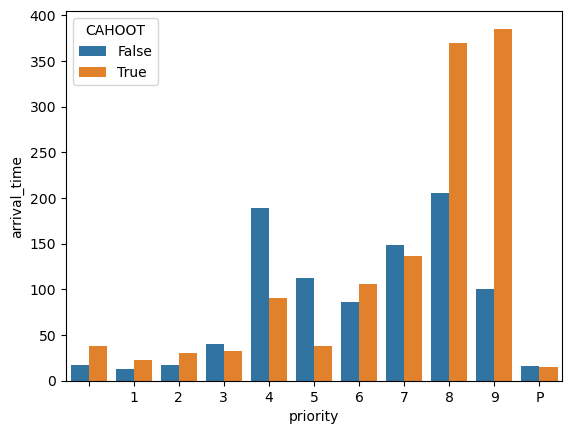

In [38]:
sns.barplot(times, x="priority", y="arrival_time", hue="CAHOOT")

In [39]:
CAHOOT = call_data[call_data["CAHOOT"] == True]
t = CAHOOT["nature"].value_counts()
natures = t[t>1000]
natures.index

Index(['ASSIST PUBLIC- POLICE', 'CHECK WELFARE', 'TRANSPORT',
       'PUBLIC ASSIST, CAHOOTS', 'CHECK WELFARE, CAHOOTS', 'SUICIDAL SUBJECT',
       'SUICIDAL SUBJECT, CAHOOTS', 'TRANSPORT, CAHOOTS',
       'INTOXICATED SUBJECT', 'ASSIST PD, CAHOOTS', 'DISORDERLY SUBJECT',
       'FOUND SYRINGE', 'TRAFFIC HAZARD', 'ASSIST FIRE DEPARTMENT'],
      dtype='object', name='nature')

In [40]:
stats.ttest_ind(call_data[(call_data["CAHOOT"] == True) & (call_data["priority"] == "6")]["arrival_time"], call_data[(call_data["CAHOOT"] == False) & (call_data["priority"] == "6")]["arrival_time"])


TtestResult(statistic=27.827563670056865, pvalue=3.246976880667518e-170, df=313911.0)

In [41]:
call_data[(call_data["CAHOOT"] == True) & (call_data["priority"] == "6")]["arrival_time"]

663          0.000000
762          0.000000
2688         0.000000
2699         0.000000
3273         0.000000
              ...    
1451486     53.383333
1455678     22.383333
1456003    377.083333
1456029     21.966667
1456036     24.250000
Name: arrival_time, Length: 1659, dtype: float64

In [42]:
def ttest(column, value, time_type):
    cahoot = call_data[(call_data["CAHOOT"] == True) & (call_data[column] == value)][time_type]
    epd = call_data[(call_data["CAHOOT"] == False) & (call_data[column] == value)][time_type]
    ttest_r = stats.ttest_ind(cahoot,epd)
    print(f"CAHOOT average {time_type} for {column} of {value} is: {round(np.mean(cahoot), 3)} min for {len(cahoot)} calls")
    print(f"EPD average {time_type} for {column} of {value} is: {round(np.mean(epd), 3)} min for {len(epd)} calls")
    print(f"Two sample t-test, t-stat: {round(ttest_r[0], 3)}, p-value: {round(ttest_r[1], 5)}")
    return

In [94]:
ttest("Hour",10,"arrival_time")

CAHOOT average arrival_time for Hour of 10 is: 103.493 min for 6707 calls
EPD average arrival_time for Hour of 10 is: 46.885 min for 42871 calls
Two sample t-test, t-stat: 30.401, p-value: 0.0


Text(0.5, 1.0, 'CAHOOT and Non-CAHOOT Unit Arrival Times by Hour')

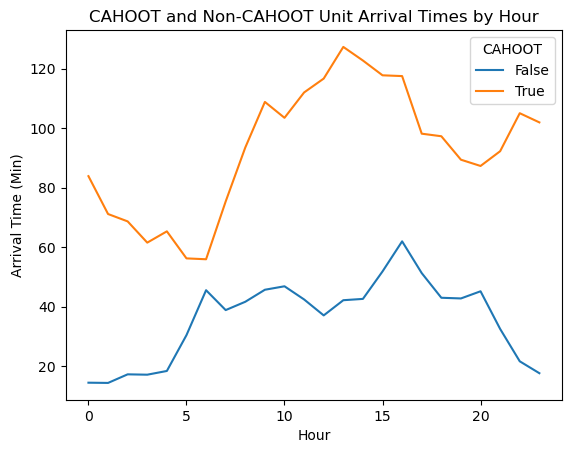

In [44]:
sns.lineplot(call_data, x = "Hour", y = "arrival_time", hue = "CAHOOT",errorbar=None)
plt.xlabel("Hour")
plt.ylabel("Arrival Time (Min)")
plt.title("CAHOOT and Non-CAHOOT Unit Arrival Times by Hour")

In [45]:
df_sorted = call_data
df_sorted = df_sorted.sort_values('DoW')

In [46]:
df_sorted['DoW'] = df_sorted['DoW'].replace(0, 'Mon')
df_sorted['DoW'] = df_sorted['DoW'].replace(1, 'Tues')
df_sorted['DoW'] = df_sorted['DoW'].replace(2, 'Wed')
df_sorted['DoW'] = df_sorted['DoW'].replace(3, 'Thurs')
df_sorted['DoW'] = df_sorted['DoW'].replace(4, 'Fri')
df_sorted['DoW'] = df_sorted['DoW'].replace(5, 'Sat')
df_sorted['DoW'] = df_sorted['DoW'].replace(6, 'Sun')

Text(0.5, 1.0, 'CAHOOT and Non-CAHOOT Unit Arrival Times by Day of The Week')

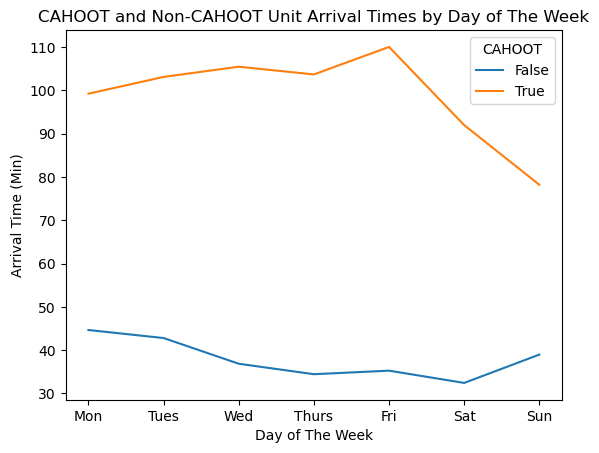

In [47]:
#DoW_order = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
sns.lineplot(df_sorted, x = "DoW", y = "arrival_time", hue = "CAHOOT",errorbar=None) #, order = DoW_order
plt.xlabel("Day of The Week")
plt.ylabel("Arrival Time (Min)")
plt.title("CAHOOT and Non-CAHOOT Unit Arrival Times by Day of The Week")

Text(0.5, 1.0, 'CAHOOT and Non-CAHOOT Unit Arrival Times by Call Priority')

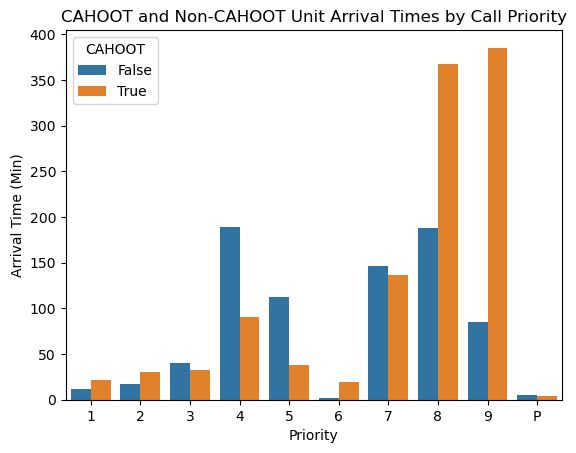

In [48]:
orders =  ["1", "2", "3", "4", "5", "6", "7", "8", "9", "P"]
sns.barplot(call_data, x = "priority", y = "arrival_time", hue = "CAHOOT", order = orders, errorbar = None)
plt.xlabel("Priority")
plt.ylabel("Arrival Time (Min)")
plt.title("CAHOOT and Non-CAHOOT Unit Arrival Times by Call Priority")

Cahoots appears to be slower in most cases than EPD but it could be because Cahoots does not haave access to sirens

## Clear Times

<Axes: xlabel='priority', ylabel='clear_time'>

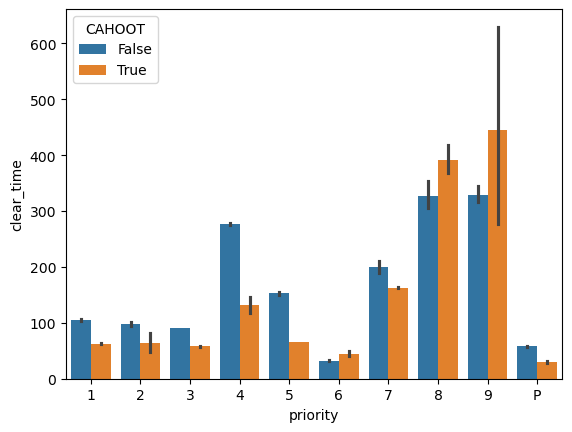

In [56]:
sns.barplot(call_data, x = "priority", y = "clear_time", hue = "CAHOOT", order = orders)

In [57]:
#sns.barplot(call_data, x = "priority", y = "dispatch_time", hue = "CAHOOT", order = orders)

<Axes: xlabel='Hour', ylabel='clear_time'>

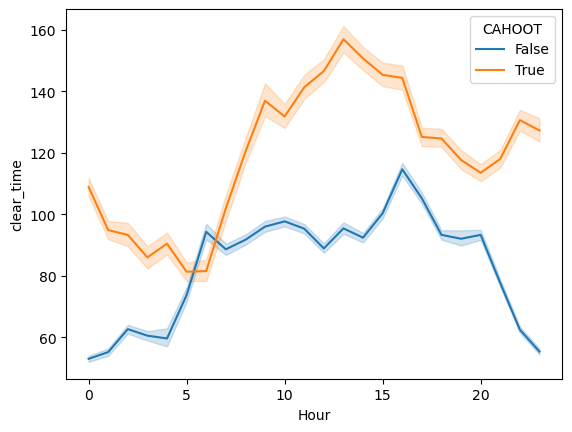

In [58]:
sns.lineplot(call_data, x = "Hour", y = "clear_time", hue = "CAHOOT")

In [61]:
nats = call_data[call_data["nature"].isin(['ASSIST PUBLIC- POLICE', 'CHECK WELFARE', 'TRANSPORT',
       'PUBLIC ASSIST, CAHOOTS', 'CHECK WELFARE, CAHOOTS', 'SUICIDAL SUBJECT',
       'SUICIDAL SUBJECT, CAHOOTS', 'TRANSPORT, CAHOOTS',
       'INTOXICATED SUBJECT', 'ASSIST PD, CAHOOTS', 'DISORDERLY SUBJECT',
       'FOUND SYRINGE', 'TRAFFIC HAZARD', 'ASSIST FIRE DEPARTMENT'])]

In [62]:
nats.head()

,yr,service,inci_id,calltime,case_id,callsource,nature,closecode,closed_as,secs_to_disp,...,zip,primeunit,units_dispd,units_arrived,dispatch_time,arrival_time,clear_time,CAHOOT,Hour,DoW
44,2014,LAW,14000107,2014-01-01 01:55:39.000,NaN,PHONE,TRANSPORT,TRAN,TRANSPORT MADE,1213.0,...,97401,CAHOOT,1,1,20.216667,30.550000,38.983333,True,1,2
52,2014,LAW,14000124,2014-01-01 02:26:18.000,NaN,W911,DISORDERLY SUBJECT,RSLV,RESOLVED,172.0,...,97402,7E28,2,2,2.866667,6.833333,41.750000,False,2,2
68,2014,LAW,14000173,2014-01-01 03:31:56.000,NaN,E911,DISORDERLY SUBJECT,GOA,GONE ON ARRIVAL,1691.0,...,97401,7X71,1,1,28.183333,28.233333,28.283333,False,3,2
80,2014,LAW,14000218,2014-01-01 05:43:22.000,NaN,SELF,INTOXICATED SUBJECT,RSLV,RESOLVED,0.0,...,97401,7E35,1,1,0.000000,0.000000,5.033333,False,5,2
82,2014,LAW,14000224,2014-01-01 06:05:04.000,NaN,PHONE,CHECK WELFARE,PCHK,PATROL CHECK,5003.0,...,97402,1E83,2,2,83.383333,97.750000,115.300000,False,6,2


Text(0.5, 1.0, 'CAHOOT and Non-CAHOOT Unit Arrival Times by Call Nature')

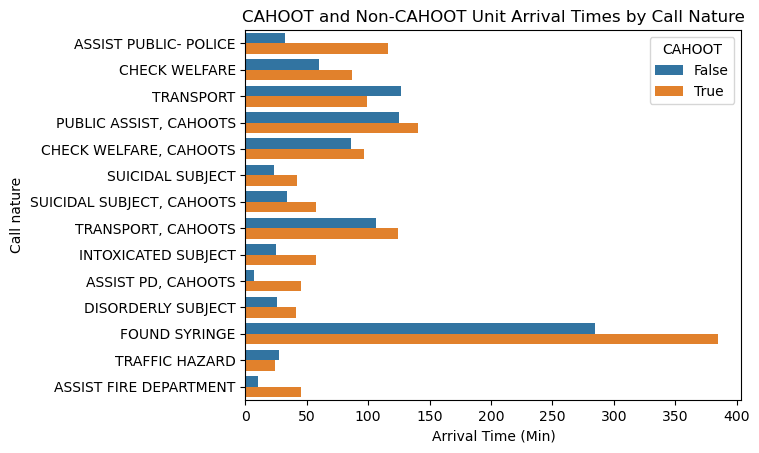

In [64]:
nat_order = ['ASSIST PUBLIC- POLICE', 'CHECK WELFARE', 'TRANSPORT',
       'PUBLIC ASSIST, CAHOOTS', 'CHECK WELFARE, CAHOOTS', 'SUICIDAL SUBJECT',
       'SUICIDAL SUBJECT, CAHOOTS', 'TRANSPORT, CAHOOTS',
       'INTOXICATED SUBJECT', 'ASSIST PD, CAHOOTS', 'DISORDERLY SUBJECT',
       'FOUND SYRINGE', 'TRAFFIC HAZARD', 'ASSIST FIRE DEPARTMENT']
sns.barplot(nats, y = "nature", x = "arrival_time", hue = "CAHOOT", order = nat_order, errorbar = None)
plt.ylabel("Call nature")
plt.xlabel("Arrival Time (Min)")
plt.title("CAHOOT and Non-CAHOOT Unit Arrival Times by Call Nature")

In [66]:
call_data[["yr","calltime","nature","dispatch_time","arrival_time","clear_time","CAHOOT","Hour","DoW"]].sample(10)

,yr,calltime,nature,dispatch_time,arrival_time,clear_time,CAHOOT,Hour,DoW
672648,2019,2019-05-04 10:21:33.000,TRAFFIC HAZARD,6.333333,23.466667,35.100000,False,10,5
211757,2015,2015-09-22 20:20:03.000,ATTEMPT TO LOCATE,138.016667,152.850000,230.233333,False,20,1
1165848,2022,2022-11-16 22:35:04.000,TRAFFIC STOP,0.000000,0.000000,30.483333,False,22,2
801079,2020,2020-03-30 11:35:45.000,CRIMINAL TRESPASS,12.583333,22.200000,64.183333,False,11,0
823047,2020,2020-05-26 22:02:55.000,TRAFFIC STOP,0.000000,0.000000,0.733333,False,22,1
596801,2018,2018-09-28 07:31:19.000,RUNAWAY JUVENILE,78.666667,94.116667,161.266667,False,7,4
1482299,2025,2025-04-03 13:58:22.000,PATROL CHECK,0.000000,0.000000,2.783333,False,13,3
23898,2014,2014-03-18 12:45:28.000,PERSON STOP,0.000000,0.000000,1.350000,False,12,1
416951,2017,2017-05-13 06:49:42.000,HIT AND RUN,36.316667,57.250000,588.600000,False,6,5
359499,2016,2016-11-25 00:37:07.000,TRAFFIC STOP,0.000000,0.000000,13.233333,False,0,4
